In [2]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

c:\Users\jasra\OneDrive\Desktop\mmdp_project\yolov5


Cloning into 'yolov5'...


HEAD is now at 064365d Update parse_opt() in export.py to work as in train.py (#10789)


In [1]:
%cd yolov5

c:\Users\jasra\OneDrive\Desktop\mmdp_project\yolov5


In [2]:
!pip install -qr requirements.txt
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.1.0+cpu CPU


In [4]:
!pip install -q roboflow

from roboflow import Roboflow

rf = Roboflow(api_key="aSBxuf63O69YnAultI1I")
project = rf.workspace("karel-cornelis-q2qqg").project("aicook-lcv4d")
dataset = project.version(3).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to aicook-3 in yolov5pytorch:: 100%|██████████| 6112/6112 [00:03<00:00, 1930.06it/s]


In [5]:
%cd C:\Users\jasra\OneDrive\Desktop\mmdp_project\yolov5

C:\Users\jasra\OneDrive\Desktop\mmdp_project\yolov5


In [5]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- apple
- banana
- beef
- blueberries
- bread
- butter
- carrot
- cheese
- chicken
- chicken_breast
- chocolate
- corn
- eggs
- flour
- goat_cheese
- green_beans
- ground_beef
- ham
- heavy_cream
- lime
- milk
- mushrooms
- onion
- potato
- shrimp
- spinach
- strawberries
- sugar
- sweet_potato
- tomato
nc: 30
train: aicook-3/train/images
val: aicook-3/valid/images


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [6]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [1]:
1+1

2

In [ ]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

## TRAINING MODEL


In [2]:
%%time
!python train.py --img 640 --batch 16 --epochs 30 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

CPU times: total: 0 ns
Wall time: 48.1 ms


python: can't open file 'c:\\Users\\jasra\\OneDrive\\Desktop\\mmdp_project\\train.py': [Errno 2] No such file or directory


# Evaluate Custom YOLOv5 Detector Performance

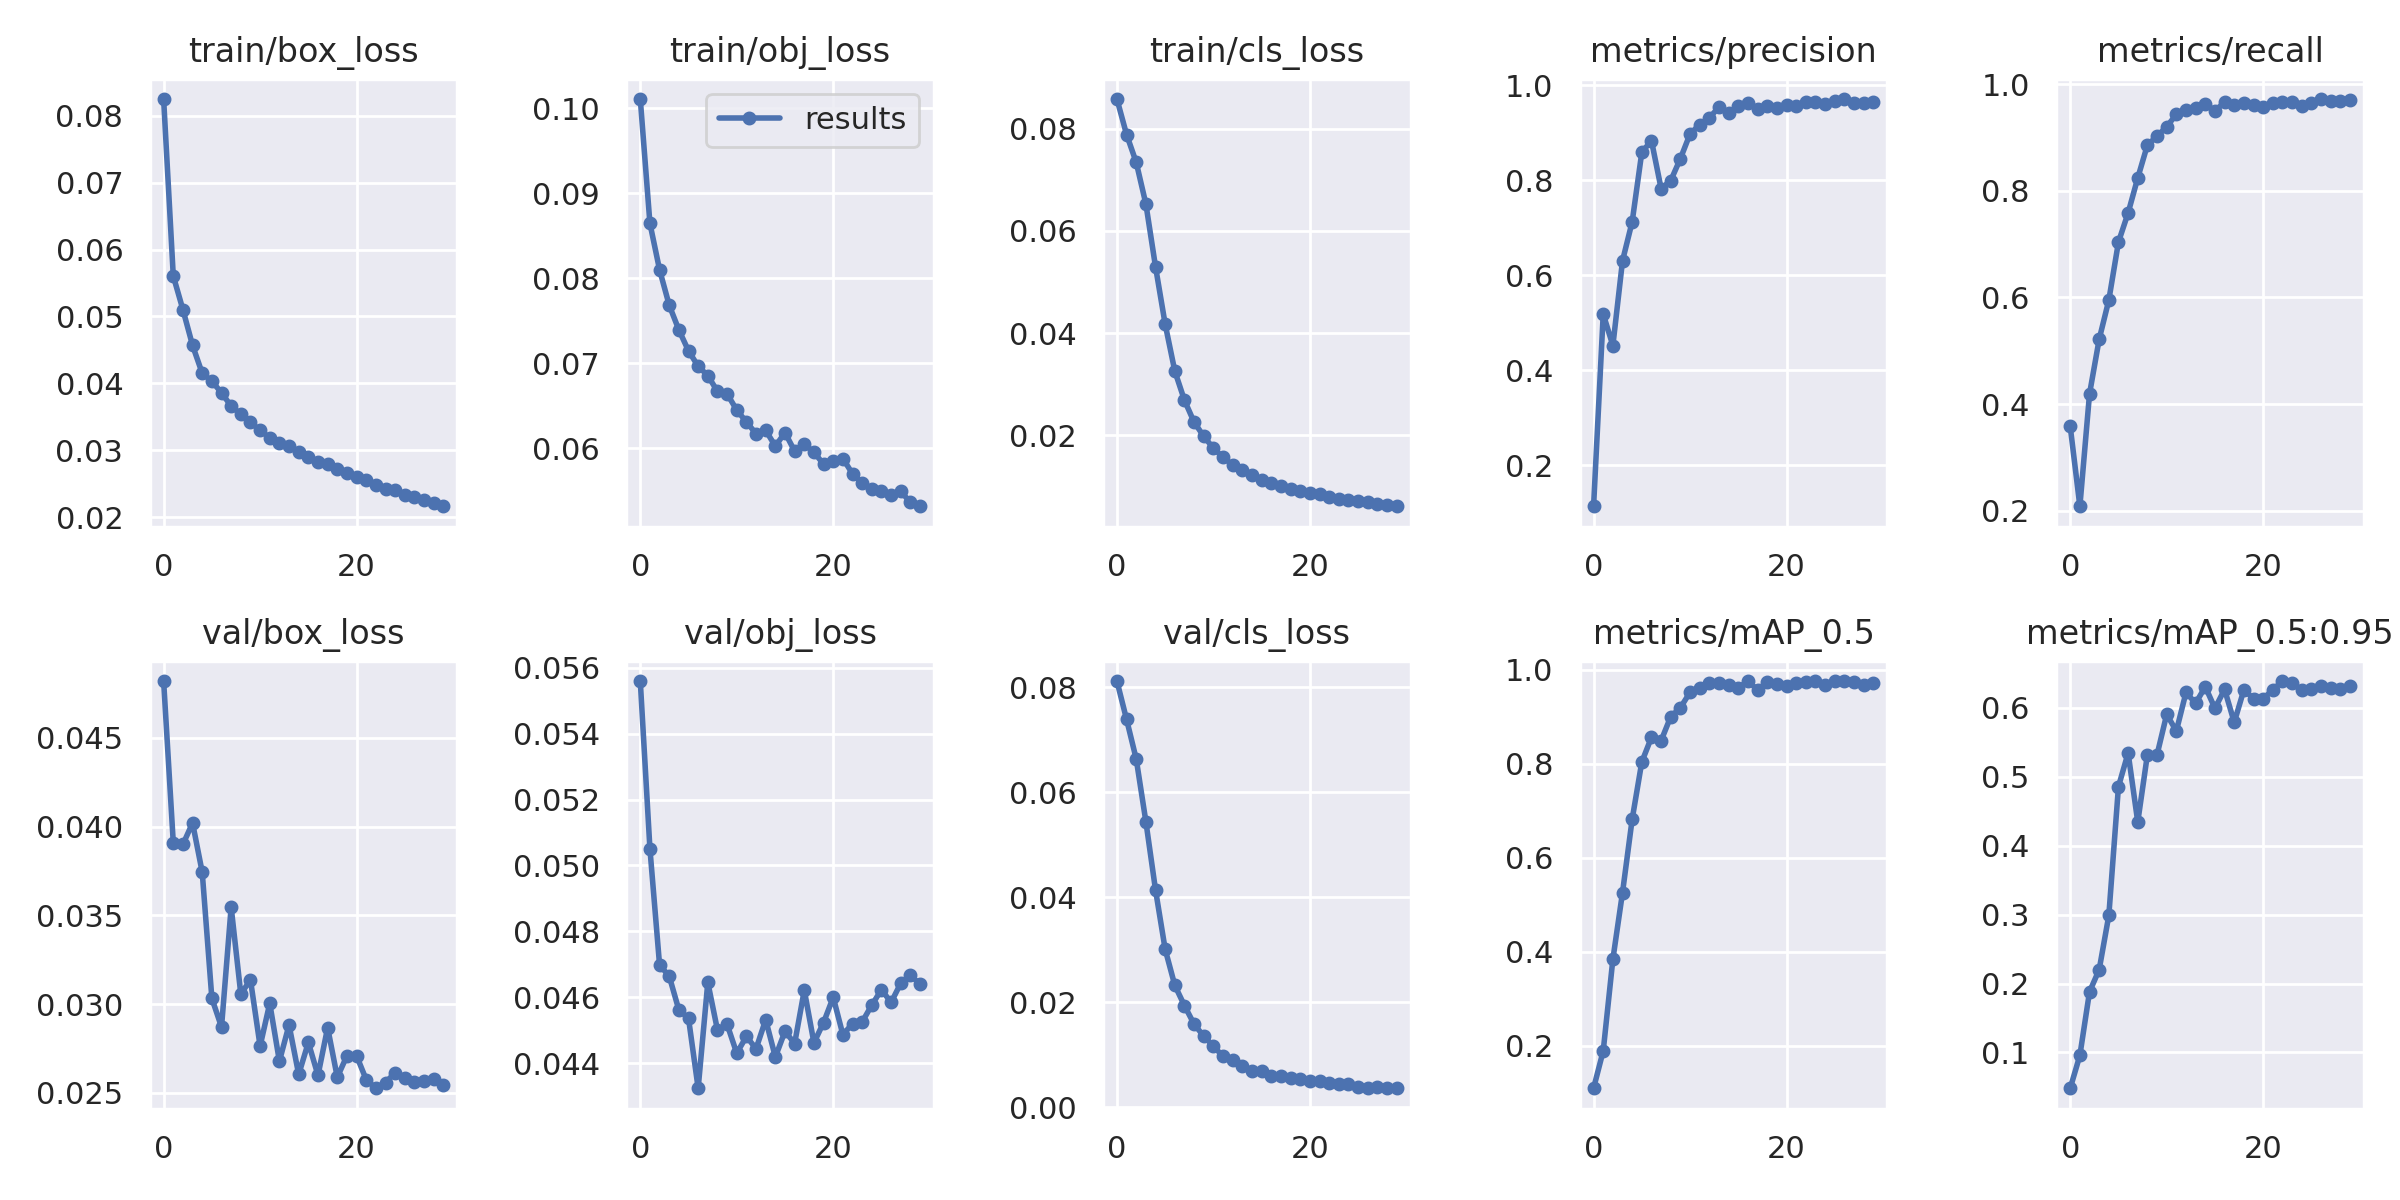

In [4]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='C:\\Users\\jasra\\OneDrive\\Desktop\\mmdp_project\\yolov5\\runs\\train\\exp\\results.png', width=1000)  # view results.png

insert photos

12


TEST BY CUSTOM IMAGE


In [119]:
img = input("type the name of image that you want: ")
flavour = input("what flavour do you want out of [sweet,sour,savoury,bitter,umami,any]: ")

In [120]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 1280 --conf 0.25 --source ../{img}

detect: weights=['runs/train/exp/weights/best.pt'], source=../test3.jpg, data=data\coco128.yaml, imgsz=[1280, 1280], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-72-g064365d Python-3.9.7 torch-2.1.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7091035 parameters, 0 gradients, 16.0 GFLOPs
image 1/1 C:\Users\jasra\OneDrive\Desktop\mmdp_project\test3.jpg: 1280x1280 2 apples, 1 blueberries, 1 cheese, 1 eggs, 1 flour, 1 green_beans, 1 ground_beef, 1 onion, 1 potato, 3 spinachs, 666.3ms
Speed: 0.9ms pre-process, 666.3ms inference, 1.4ms NMS per image at shape (1, 3, 1280, 1280)
Results saved to runs\detect\exp6
1 labels saved to runs\detect\exp6\labels


In [ ]:
!python -m pip install cohere

In [121]:
data= ""
with open("currentfolder.txt",'r') as f:
    data = f.read()
print(data)

C:/Users/jasra/OneDrive/Desktop/mmdp_project/yolov5/runs/detect/exp5


In [122]:
import re
match = re.search(r'exp(\d+)', data)
numplusone = 0
if match:
    # Extract the number
    numplusone = int(match.group(1))

#increament of current trial
numplusone = numplusone+1
new_text = re.sub(r'exp\d+', 'exp', data)
txt = f"{new_text}{numplusone}"



In [123]:
f.close()

with open("currentfolder.txt", 'w') as file:
    file.truncate(0)
print(f"Contents of have been removed.")
file.close()

Contents of have been removed.


In [124]:
with open("currentfolder.txt", 'w') as file:
    file.write(txt)
print(f'Text written to')
file.close()

Text written to


In [125]:
prefix= ""
with open("currentfolder.txt",'r') as f:
    prefix = f.read()

dot_index = img.rfind('.') #getting txtfile name
result = ""
if dot_index != -1:
    result = img[:dot_index]
else:
    result = img
txtfile = result + ".txt"
f.close()
mid = "/labels/"
destpath = f'{prefix}{mid}{txtfile}'
print(destpath)

C:/Users/jasra/OneDrive/Desktop/mmdp_project/yolov5/runs/detect/exp6/labels/test3.txt


In [16]:
import cohere

In [17]:
co = cohere.Client('J4Syy5U88TUc8KxWiFsG8K3OQQqPRGOjQCWGIodj')

In [129]:
premessage="You are an expert chef. I will give you a list of ingredients separated by a comma followed by the flavour of the dish, and you will give me a recipe using all or most of them but not supplementing outside of what might appear on this list. If an ingredient is shown as None, ignore it. If flavour is any then ignore it. Give each recipe a catchy title, an approximate time to complete and a count of people served. Also like any recipe, include the ingredient portions in the list labelled Ingredients: and then the Instructions section as a numbered list. Here's the ingredient list:"
postmessage=""
flavtext=".Here's the flavour of the dish: "
with open(destpath,'r') as file:
    postmessage = file.read()
message = f'{premessage}{postmessage}{flavtext}{flavour}'
response = co.generate(
  prompt=message,
)

You are an expert chef. I will give you a list of ingredients separated by a comma followed by the flavour of the dish, and you will give me a recipe using all or most of them but not supplementing outside of what might appear on this list. If an ingredient is shown as None, ignore it. If flavour is any then ignore it. Give each recipe a catchy title, an approximate time to complete and a count of people served. Also like any recipe, include the ingredient portions in the list labelled Ingredients: and then the Instructions section as a numbered list. Here's the ingredient list:apples, blueberries, cheese, eggs, flour, green_beans, ground_beef, onion, potato, spinachs, .Here's the flavour of the dish: bitter


In [128]:
print(response[0])

 Sure! Here's a recipe that uses most of the ingredients and suits the bitter flavour:

### Spinach and Green Bean Frittata 

**Ingredients:**
- 1 pound ground beef
- 1 cup chopped onion
- 2 cups frozen chopped spinach, thawed and drained
- 1 cup frozen green beans, thawed and drained
- 1/2 cup shredded cheese
- 1/3 cup chopped apple
- 2 tablespoons chopped fresh parsley
- 1 teaspoon salt
- 1/2 teaspoon ground black pepper
- 8 eggs
- 1 cup milk
- 1 cup flour 

**Instructions:**
1. Preheat oven to 350°F.
2. In a large skillet, cook and crumble the ground beef and onion over medium heat until the beef is no longer pink; drain. Stir in the spinach, green beans, cheese, apple, parsley, salt and pepper.
3. In a large bowl, whisk together the eggs, milk and flour. Pour over the beef mixture and stir until well combined.
4. Pour the mixture into a 9-inch pie plate.
5. Bake for 30 to 35 minutes or until a knife inserted near the center comes out clean.
6. Serve with a side salad and crusty bre

In [130]:
temp = co.chat(
    message=message,
    connectors=[{"id": "web-search"}]
)

In [131]:
print(temp.text)

title: Blueberry and Green Bean Quiche
served: 6 - 8 people
preparation_time: roughly 1 hour and 10 minutes
Ingredients:
1 cup all-purpose flour
1 teaspoon baking powder
1/2 teaspoon salt
1/4 cup butter, melted
1 cup milk
3 eggs
1 cup shredded cheddar cheese
1 cup fresh or frozen green beans, trimmed and halved
1 cup fresh or frozen blueberries

Instructions:
1. Preheat oven to 375 degrees F (190 degrees C).
2. In a large bowl, combine flour, baking powder, and salt. Stir in butter and milk until mixture is just moistened.
3. Press mixture into a 9-inch quiche dish. Bake for 15 minutes, or until crust is golden brown.
4. In a medium bowl, beat eggs and cheese. Stir in green beans and blueberries. Pour over hot crust.
5. Bake for an additional 35 to 40 minutes, or until a knife inserted in the center comes out clean.
6. Let quiche cool for 10 minutes before slicing and serving. Enjoy!
